# Model-Predictive Path Integral Control Example

In [1]:
%load_ext autoreload
%autoreload 2

## Imports and Parameters

In [54]:
import time
from utils import * # imports integrators and other useful things
from system import * # imports system dynamics and objective
from MPPI import MPPI # imports controller
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

###################
# System parameters
x0 = np.array([0,0,0,0,1.7,0,0,0])
xd = np.array([0,0,0,0,1.4,0,0,0])
del_t = 0.05
dyn = lambda x, u: SLIP_walker_3D(x,u) 

######################
# Objective parameters
w_sz = 10; ov = 0.5;
R = 20.0*np.diag([1.0, 1.0, 1.0])
Q = 1.0*np.diag([0.0, 10.0, 0.0, 10.0, 100.0, 10.0, 0.0, 0.0])
u0 = np.array([0.0, 0.0, 0.0])
var_ind = [0,2]
mean1 = np.array([-1.5,-1.5])
mean2 = np.array([1.5, 1.5])
cov1 = 1.*np.diag([1, 1])
cov2 = 1.*np.diag([1, 1])
w1 = 100 # weight on bimodal dist
w2 = -1 # weight on rattling
obj = lambda x, u: SLIP_objective_3D(x, u, mean1, cov1, mean2, cov2, \
                                     var_ind, del_t, w1, w2, w_sz, ov, \
                                     xd, Q, R)

#######################
# Controller parameters
noise_mean = np.array([0.0, 0.0, 0.0])
noise_var = 0.1*np.diag([1.0,1.0,1.0])
samp_num = 50 # 100 was good for diff
predictive_horizon = 40 # 100 was good for diff
simulation_length = 5000 # 1000 was good for diff
Temp = 1.0

## Initialize Controller

In [40]:
controller = MPPI(dyn, obj, x0, u0, K=samp_num, N=predictive_horizon, dt=del_t, lamb=Temp, noise_mu=noise_mean, noise_sigma=noise_var)

## Main Loop

In [41]:
tic = time.time()
xlist = []
ulist = []
costlist = []
for i in range(simulation_length):
    u_star = controller.step(x0)[:,0]
    x = integrate(dyn,x0,u_star,del_t)
    x0 = np.copy(x)
    xlist.append(x0)
    ulist.append(u_star)
    costlist.append(np.mean(controller.cost_total))
    if (i+1) % int(simulation_length/4.0) == 0:
        print(str(int(100.0*((float(i+1)/float(simulation_length)))))+"% complete. Time elapsed: "+str(np.round(time.time()-tic,2))+"s.")
xtraj = np.array(xlist).T
utraj = np.array(ulist).T

25% complete. Time elapsed: 444.23s.
50% complete. Time elapsed: 911.94s.
75% complete. Time elapsed: 1380.92s.
100% complete. Time elapsed: 1837.57s.


In [48]:
# np.savetxt('SLIP_3D_xtraj.csv',xtraj.T,delimiter=',')
# np.savetxt('SLIP_3D_utraj.csv',utraj.T,delimiter=',')

## Plot

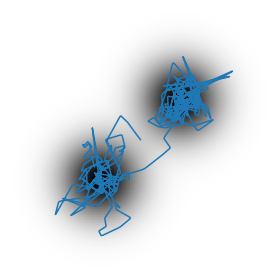

In [55]:
fun = lambda x: bimodal_objective(x, mean1, cov1, mean2, cov2)
XY = np.zeros((100,100))
v = np.linspace(-5,5,100)
for i in range(len(v)):
    for j in range(len(v)):
        XY[i,j] = w1*fun(np.array([v[i],v[j]]))
        
plt.figure()
plt.imshow(np.flip(XY,axis=1),cmap="gist_gray",extent=[-5,5,-5,5])
# plt.scatter(xtraj[0], xtraj[1], s=15, alpha=0.5)
plt.plot(xtraj[0], xtraj[2])
plt.xlim([-5,5])
plt.ylim([-5,5])
# plt.xlabel("x")
# plt.xlabel("y")
plt.axis("off")
plt.tight_layout()
plt.show()

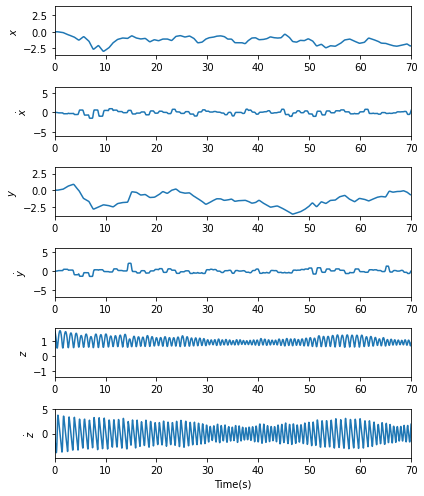

In [56]:
tvec = np.linspace(0,del_t*xtraj.shape[1],xtraj.shape[1])
# lims = [tvec[0],tvec[-1]]
lims = [0,70]

plt.figure(figsize=(6,7))
label_list = [r'$x$',r'$\dot{x}$',r'$y$',r'$\dot{y}$',r'$z$',r'$\dot{z}$',r'$u_1$',r'$u_2$']
for i in range(1,7):
    plt.subplot(6,1,i)
    plt.plot(tvec,xtraj[i-1])
    plt.xlim(lims)
    plt.ylabel(label_list[i-1])
# plt.subplot(6,1,5)
# plt.plot(tvec,utraj[0])
# plt.xlim(lims)
# plt.ylabel(label_list[4])
# plt.subplot(6,1,6)
# plt.plot(tvec,utraj[1])
# plt.xlim(lims)
# plt.ylabel(label_list[5])
plt.xlabel('Time(s)')
plt.tight_layout()
plt.show()

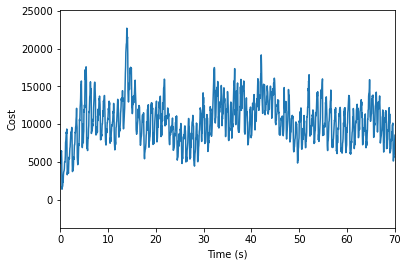

In [57]:
plt.figure()
plt.plot(tvec,costlist)
plt.xlabel('Time (s)')
plt.ylabel('Cost')
plt.xlim(lims)
plt.show()

In [ ]:
plt.close('all')